# Accessing GaiaArchive with TAP+

In this tutorial, we go through how to access, examine and use Gaia TAP+ service using **gapipes**.
For databases as large as Gaia (and many other large astronomical surveys for that matter),
downloading everything as a set of files is no longer practical.
The Table Access Protocol (TAP) was designed for the purpse of communicating general tabular data by the [IVOA](http://www.ivoa.net/).
For [Gaia](http://gea.esac.esa.int/archive/) and other ESA Services, the ESDC extended this protocol, called TAP+.
The extension includes user table space, sharing tables among groups, and listing jobs.


## Why another Gaia TAP client?

There is already a TAP python client in the popular [astroquery](https://astroquery.readthedocs.io/en/latest/). So why another one?

The current implementation in astroquery is excessively verbose, has clunky api design, does not report an informative error message and does not nicely cover all the 'quarks' of GaiaArchive. This module is written more or less out of frustration.
If astroquery eventually change to implementation that uses [pyvo](http://pyvo.readthedocs.io), which has a much well-defined code structure and cleaner interface, this module can retire.

## Getting started

In **gapipes**, there are two core classes that interfaces these services:
one for plain TAP (`gapipes.TAP`) and one for GaiaTAP+ (`gapipes.GaiaTapPlus`).
While they are written so that you can point at any available service,
a default instance `gapipes.gaia` is already defined pointing at [the official Gaia Archive](http://gea.esac.esa.int/archive/).

**NOTE** Following [Yagni](https://en.wikipedia.org/wiki/You_aren%27t_gonna_need_it) principle, **gapipes** does not implement _all_ [capabilities of Gaia TAP+](http://gea.esac.esa.int/archive-help/index.html) such as sharing tables with other users. If you need any missing feature of Gaia TAP+ in **gapipes**, feel free to open [an issue or a pull request](https://github.com/smoh/gapipes).

In [1]:
import gapipes as gp

gp.gaia

GaiaTapPlus("gea.esac.esa.int", "/tap-server/tap", "https", 443)

## Inspecting table meta data

The list of tables and columns available can be inspected using `tables` and `columns` attribute, which are pandas DataFrames.

In [2]:
print('total number of tables:', len(gp.gaia.tables))
gp.gaia.tables.head()

total number of tables: 80


,schema,table_name,description
0,public,hipparcos,hipparcos original catalogue (J1991.25)
1,public,hipparcos_newreduction,Hipparcos New Reduction: The Astrometric Catal...
2,public,hubble_sc,Hubble Source Catalogue
3,public,igsl_source,null
4,public,igsl_source_catalog_ids,SourceId in original catalogues


In [3]:
gp.gaia.columns.head()

,schema,table_name,column_name,unit,dtype,description
0,public,hipparcos,astroref,,VARCHAR,
1,public,hipparcos,bd,,VARCHAR,
2,public,hipparcos,btmag,,REAL,
3,public,hipparcos,b_v,,REAL,
4,public,hipparcos,ccdm,,VARCHAR,


So you can easily filter these tables using pandas methods.

In [4]:
gp.gaia.tables.query('schema == "public"')

,schema,table_name,description
0,public,hipparcos,hipparcos original catalogue (J1991.25)
1,public,hipparcos_newreduction,Hipparcos New Reduction: The Astrometric Catal...
2,public,hubble_sc,Hubble Source Catalogue
3,public,igsl_source,null
4,public,igsl_source_catalog_ids,SourceId in original catalogues
5,public,tycho2,The Tycho-2 Catalogue is an astrometric refere...
6,public,dual,auxiliary table to be used as dummy from


In [5]:
gp.gaia.tables.query('table_name == "gaia_source"')

,schema,table_name,description
37,gaiadr1,gaia_source,This table has an entry for every Gaia observe...
78,gaiadr2,gaia_source,This table has an entry for every Gaia observe...


Have a look at one particular table in detail.

In [6]:
gp.gaia.columns.query('(table_name == "gaia_source") & schema == "gaiadr2"').head()

,schema,table_name,column_name,unit,dtype,description
1531,gaiadr2,gaia_source,solution_id,,BIGINT,Solution Identifier
1532,gaiadr2,gaia_source,designation,,VARCHAR,Unique source designation (unique across all D...
1533,gaiadr2,gaia_source,source_id,,BIGINT,Unique source identifier (unique within a part...
1534,gaiadr2,gaia_source,random_index,,BIGINT,Random index used to select subsets
1535,gaiadr2,gaia_source,ref_epoch,yr,DOUBLE,Reference epoch


### Getting information about specific table(s)

You can also get information about specific tables with GaiaTAP+.

In [7]:
tables, columns = gp.gaia.get_table_info(only_tables=True)

In [8]:
tables

,schema,table_name,description
0,public,hipparcos,hipparcos original catalogue (J1991.25)
1,public,hipparcos_newreduction,Hipparcos New Reduction: The Astrometric Catal...
2,public,hubble_sc,Hubble Source Catalogue
3,public,igsl_source,null
4,public,igsl_source_catalog_ids,SourceId in original catalogues
...,...,...,...
75,gaiadr2,vari_short_timescale,This table describes the short-timescale sourc...
76,gaiadr2,vari_time_series_statistics,"Statistical parameters of time series, using o..."
77,gaiadr2,panstarrs1_original_valid,The Panoramic Survey Telescope and Rapid Respo...
78,gaiadr2,gaia_source,This table has an entry for every Gaia observe...


In [9]:
# count number of columns for each schema
columns.groupby('schema')

## Query the Gaia database

There are two kinds of queries supported: synchronous and asynchonous.

Let's start with synchonous queries.

### Synchronous queries

Use `.query` to send an ADQL query to the database. The default behaviour is to request output in csv format and read resulting table as pandas.DataFrame.

In [20]:
r = gp.gaia.query('select top 10 * from gaiadr2.gaia_source', output_format='csv')
print(type(r))
import pandas as pd
pd.set_option('display.max_columns', 8, 'display.max_colwidth', 10)
r.head()

<class 'pandas.core.frame.DataFrame'>


,solution_id,designation,source_id,random_index,...,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url
0,163572...,Gaia D...,387526...,459847817,...,NaN,NaN,https:...,NaN
1,163572...,Gaia D...,387502...,229923908,...,NaN,NaN,https:...,NaN
2,163572...,Gaia D...,387646...,114961954,...,NaN,NaN,https:...,NaN
3,163572...,Gaia D...,387506...,57480977,...,0.909308,1.484657,https:...,NaN
4,163572...,Gaia D...,387649...,108811...,...,NaN,NaN,https:...,NaN


Wrong queries will raise exception with a useful message from the server.

In [9]:
r = gp.gaia.query('select top 5 * from foo.bar')

HTTPError: Cannot parse query 'select top 5 * from foo.bar' for job '1550666502785O': 1 unresolved identifiers: bar [l.1 c.21 - l.1 c.28] !

### Asynchronous queries

For a more complicated queries that takes longer than 30 seconds,
use `.query_async`. The interface is the same except the return value is now a `Job` instance.

In [10]:
query = """
select 
    count(*) as n, 
    round(phot_g_mean_mag, 1) as val
from 
    gaiadr1.tgas_source 
group by val
order by val
"""
j = gp.gaia.query_async(query, output_format='csv', name='histogram')
j

Job(jobid='1550666562163O', phase='EXECUTING')

Use `.get_result` to wait until the job is finished and download the result.

In [11]:
%%time
r = j.get_result()

CPU times: user 29.2 ms, sys: 11.7 ms, total: 40.9 ms
Wall time: 3.42 s


In [12]:
%matplotlib inline

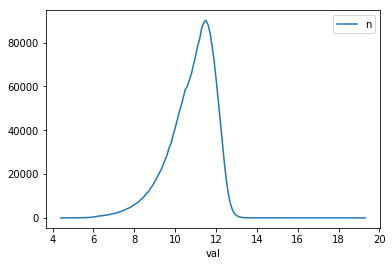

In [13]:
r.plot('val', 'n');

Inspect `Job` if needed.

In [14]:
print(j.query)


select 
    count(*) as n, 
    round(phot_g_mean_mag, 1) as val
from 
    gaiadr1.tgas_source 
group by val
order by val



In [15]:
print(j.url)
print(j.result_url)

https://gea.esac.esa.int/tap-server/tap/async/1550666562163O
https://gea.esac.esa.int/tap-server/tap/async/1550666562163O/results/result


## Using authenticated service

There are some benefits to using Gaia TAP+ authenticated service (with an account).

Log in and out of server using `gp.gaia.login` and `gp.gaia.logout`.

**NOTE**:

- Once you are logged in, the result of `get_table_info` method includes your user tables if any.
- Once you are logged in, `list_jobs` method only lists jobs you launched.

In [4]:
gp.gaia.login()

User:  soh
Password:  ············


### Managing user tables

Once you login, you can upload your own tables to user space.

In [5]:
import pandas as pd
from astropy.table import Table

mytable = Table.from_pandas(pd.DataFrame(dict(a=[1,2,3], b=[4,5,6])))
gp.gaia.upload_table(mytable, 'foobar123', table_description='test table to demonstrate upload')


"Uploaded file (size: 0) into 'foobar123'"

Let's check if the table is there.

In [6]:
gp.gaia.query('select * from user_soh.foobar123;')

,foobar123_oid,a,b
0,1,1,4
1,2,2,5
2,3,3,6


Now let's delete.

In [7]:
gp.gaia.delete_user_table('foobar123')

"Table 'foobar123' removed."

If we try to query a deleted table, we should get an error.

In [8]:
gp.gaia.query('select * from user_soh.foobar123;')

HTTPError: Cannot parse query 'select * from user_soh.foobar123;' for job '1553653744533O': 1 unresolved identifiers: foobar123 [l.1 c.15 - l.1 c.33] !